# **Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from imutils import paths
import matplotlib.pyplot as plt
import shutil
import PIL
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Dataset Loading**

In [2]:
DATASET_PATH="D:/Bachelor/ISIC 2019 Dataset"
TRAINING_PATH=DATASET_PATH+'/Training/Test'
VALIDATION_PATH=DATASET_PATH+'/Validation'
TEST_PATH=DATASET_PATH+'/Test'
GROUND_TRUTH_PATH=DATASET_PATH+'/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(GROUND_TRUTH_PATH, index_col='image')

BENIGN_TRAINING_PATH = TRAINING_PATH+'/0'
MEL_TRAINING_PATH = TRAINING_PATH+'/1'

BENIGN_TRAINING_PATHS = sorted(paths.list_images(BENIGN_TRAINING_PATH))
print("Working with {0} non-melanoma images".format(len(BENIGN_TRAINING_PATHS)))

MEL_TRAINING_PATHS = sorted(paths.list_images(MEL_TRAINING_PATH))
print("Working with {0} melanoma images".format(len(MEL_TRAINING_PATHS)))

Working with 10851 non-melanoma images
Working with 7234 melanoma images


## **Dataset Testing**

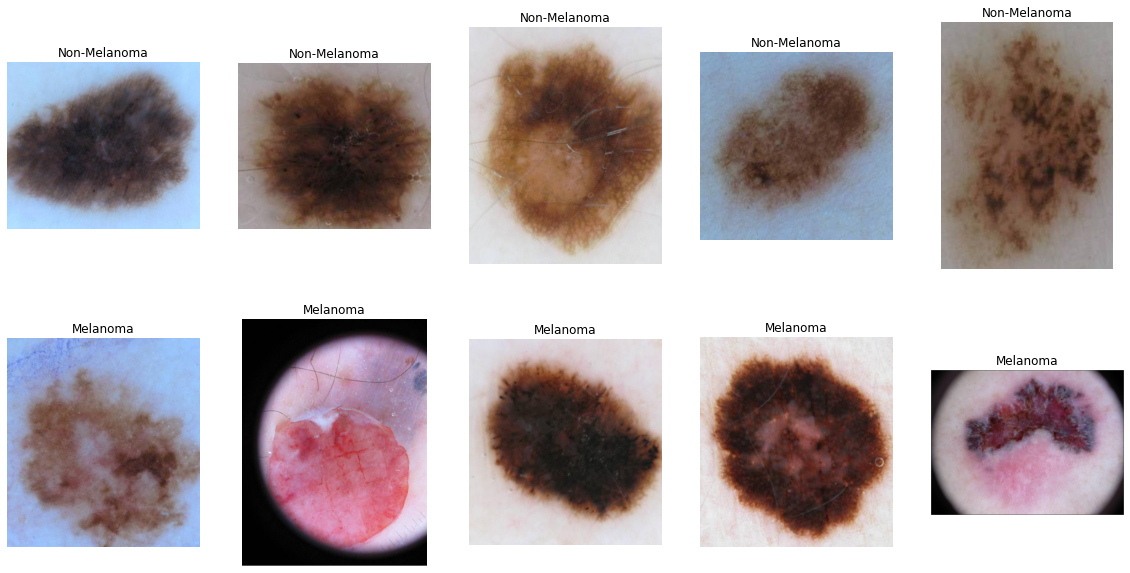

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(PIL.Image.open(BENIGN_TRAINING_PATHS[i]))
    plt.title("Non-Melanoma")
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 1+5)
    plt.imshow(PIL.Image.open(MEL_TRAINING_PATHS[i]))
    plt.title("Melanoma")
    plt.axis("off")

# **Xception**

## **Building the Model**

In [3]:
size = 299
base = tf.keras.applications.Xception(input_shape=[size,size,3], weights='imagenet', include_top=False)

base.trainable = False

# Create new model on top
inputs = keras.Input(shape=(size, size, 3))
x=inputs
x=base(x,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2,activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


## Building training and validation datasets

In [4]:
from tensorflow.keras.applications.xception import preprocess_input
batch=80
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_set = validation_datagen.flow_from_directory(VALIDATION_PATH,(size,size), batch_size=batch,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(TRAINING_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')

Found 2533 images belonging to 2 classes.
Found 18085 images belonging to 2 classes.


## **Training the top layer**

In [5]:
callbacks = [ModelCheckpoint(filepath=DATASET_PATH+'/model/Xception', 
                               verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001, restore_best_weights=True)]

start = datetime.now()

model_history=model.fit(
  train_set,
  validation_data=validation_set,
  epochs=50,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50


c:\program files\python39\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


227/227 [==============================] - 688s 3s/step - loss: 0.5732 - binary_accuracy: 0.7043 - val_loss: 0.5104 - val_binary_accuracy: 0.7647

Epoch 00001: val_loss improved from inf to 0.51037, saving model to D:/Bachelor/ISIC 2019 Dataset/model\Xception


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\Xception\assets
Epoch 2/50
227/227 [==============================] - 391s 2s/step - loss: 0.5203 - binary_accuracy: 0.7491 - val_loss: 0.4497 - val_binary_accuracy: 0.8117

Epoch 00002: val_loss improved from 0.51037 to 0.44966, saving model to D:/Bachelor/ISIC 2019 Dataset/model\Xception


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\Xception\assets
Epoch 3/50
227/227 [==============================] - 383s 2s/step - loss: 0.4998 - binary_accuracy: 0.7625 - val_loss: 0.4654 - val_binary_accuracy: 0.7923

Epoch 00003: val_loss did not improve from 0.44966
Epoch 4/50
227/227 [==============================] - 387s 2s/step - loss: 0.4921 - binary_accuracy: 0.7689 - val_loss: 0.4794 - val_binary_accuracy: 0.7817

Epoch 00004: val_loss did not improve from 0.44966
Epoch 5/50
227/227 [==============================] - 391s 2s/step - loss: 0.4834 - binary_accuracy: 0.7702 - val_loss: 0.4788 - val_binary_accuracy: 0.7821

Epoch 00005: val_loss did not improve from 0.44966
Epoch 6/50
227/227 [==============================] - 391s 2s/step - loss: 0.4800 - binary_accuracy: 0.7747 - val_loss: 0.4119 - val_binary_accuracy: 0.8283

Epoch 00006: val_loss improved from 0.44966 to 0.41188, saving model to D:/Bachelor/ISIC 2019 Dataset/model\Xception


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: D:/Bachelor/ISIC 2019 Dataset/model\Xception\assets
Epoch 7/50
227/227 [==============================] - 387s 2s/step - loss: 0.4845 - binary_accuracy: 0.7726 - val_loss: 0.4233 - val_binary_accuracy: 0.8247

Epoch 00007: val_loss did not improve from 0.41188
Epoch 8/50
227/227 [==============================] - 384s 2s/step - loss: 0.4750 - binary_accuracy: 0.7755 - val_loss: 0.4518 - val_binary_accuracy: 0.8010

Epoch 00008: val_loss did not improve from 0.41188
Epoch 9/50
227/227 [==============================] - 384s 2s/step - loss: 0.4739 - binary_accuracy: 0.7777 - val_loss: 0.4432 - val_binary_accuracy: 0.8101

Epoch 00009: val_loss did not improve from 0.41188
Epoch 10/50
227/227 [==============================] - 382s 2s/step - loss: 0.4687 - binary_accuracy: 0.7807 - val_loss: 0.4374 - val_binary_accuracy: 0.8081

Epoch 00010: val_loss did not improve from 0.41188
Epoch 11/50
227/227 [==============================] - 383s 2s/step - loss: 

## **Fine-tuning the entire model**

In [4]:
model = keras.models.load_model(DATASET_PATH+'/model/Xception')
model.layers[1].trainable=True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [5]:
from tensorflow.keras.applications.xception import preprocess_input
batch=6
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_set = validation_datagen.flow_from_directory(VALIDATION_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(TRAINING_PATH,(size,size),batch_size=batch,
                                                 class_mode = 'categorical')

Found 2533 images belonging to 2 classes.
Found 18085 images belonging to 2 classes.


In [7]:
model = keras.models.load_model(DATASET_PATH+'/model/Xception/Fine Tuned/20.h5')
callbacks = [ModelCheckpoint(filepath=DATASET_PATH+'/model/Xception/Fine Tuned/2{epoch:02d}.h5', 
                               verbose=1, save_freq=5*3015)]

start = datetime.now()

model_history=model.fit(
  train_set,
  batch_size=batch,
  validation_data=validation_set,
  epochs=10,
    callbacks=callbacks ,verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10
3015/3015 [==============================] - 1175s 389ms/step - loss: 0.0492 - binary_accuracy: 0.9810 - val_loss: 0.3846 - val_binary_accuracy: 0.9151
Epoch 2/10
3015/3015 [==============================] - 1152s 382ms/step - loss: 0.0453 - binary_accuracy: 0.9827 - val_loss: 0.3484 - val_binary_accuracy: 0.9060
Epoch 3/10
3015/3015 [==============================] - 1152s 382ms/step - loss: 0.0428 - binary_accuracy: 0.9840 - val_loss: 0.3559 - val_binary_accuracy: 0.9049
Epoch 4/10
3015/3015 [==============================] - 1154s 383ms/step - loss: 0.0392 - binary_accuracy: 0.9849 - val_loss: 0.3763 - val_binary_accuracy: 0.9025
Epoch 5/10
3015/3015 [==============================] - ETA: 0s - loss: 0.0362 - binary_accuracy: 0.9877
Epoch 00005: saving model to D:/Bachelor/ISIC 2019 Dataset/model/Xception/Fine Tuned\205.h5


c:\program files\python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


3015/3015 [==============================] - 1153s 382ms/step - loss: 0.0362 - binary_accuracy: 0.9877 - val_loss: 0.3754 - val_binary_accuracy: 0.9139
Epoch 6/10
3015/3015 [==============================] - 1153s 382ms/step - loss: 0.0340 - binary_accuracy: 0.9869 - val_loss: 0.4537 - val_binary_accuracy: 0.9112
Epoch 7/10
3015/3015 [==============================] - 1153s 382ms/step - loss: 0.0353 - binary_accuracy: 0.9862 - val_loss: 0.3840 - val_binary_accuracy: 0.9072
Epoch 8/10
3015/3015 [==============================] - 1154s 383ms/step - loss: 0.0321 - binary_accuracy: 0.9877 - val_loss: 0.4557 - val_binary_accuracy: 0.8891
Epoch 9/10
3015/3015 [==============================] - 1153s 382ms/step - loss: 0.0313 - binary_accuracy: 0.9888 - val_loss: 0.4107 - val_binary_accuracy: 0.9068
Epoch 10/10
3015/3015 [==============================] - ETA: 0s - loss: 0.0292 - binary_accuracy: 0.9895
Epoch 00010: saving model to D:/Bachelor/ISIC 2019 Dataset/model/Xception/Fine Tuned\210.h

In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_datagen.flow_from_directory(TEST_PATH,(size,size), batch_size=32,shuffle=False,
                                                 class_mode = 'categorical')
for j in range(5,21,5):
    model = keras.models.load_model(DATASET_PATH+'/model/Xception/Fine Tuned/'+str(j).zfill(2)+'.h5')
    result = model.predict(test_set, verbose=1)
    res=np.argmax(result, axis=1)
    names=test_set.filenames
    tp=0
    tn=0
    fp=0
    fn=0

    for i in range(len(names)):
      gt = names[i][0]
      filename = names[i][2:-4]
      if res[i]==0:
        if gt=='0':
          tn+=1
        else:
          fn+=1
      else:
        if gt=='0':
          fp+=1
        else:
          tp+=1
    sensitivity = round(tp*100/(tp+fn),2)
    specifity = round(tn*100/(tn+fp),2)
    accuracy = round((tp+tn)*100/(tn+tp+fn+fp),2)
    balancedAccuracy= round((sensitivity+specifity)/2,2)
    
    print(j,':')
    print(tp)
    print(tn)
    print(fp)
    print(fn)
    print('sensitivity: ',sensitivity,'%')
    print('specifity: ',specifity,'%')
    print('accuracy: ',accuracy,'%')
    print('balanced accuracy',balancedAccuracy, '%')
    
for j in range(5,11,5):
    model = keras.models.load_model(DATASET_PATH+'/model/Xception/Fine Tuned/2'+str(j).zfill(2)+'.h5')
    result = model.predict(test_set, verbose=1)
    res=np.argmax(result, axis=1)
    names=test_set.filenames
    tp=0
    tn=0
    fp=0
    fn=0

    for i in range(len(names)):
      gt = names[i][0]
      filename = names[i][2:-4]
      if res[i]==0:
        if gt=='0':
          tn+=1
        else:
          fn+=1
      else:
        if gt=='0':
          fp+=1
        else:
          tp+=1
    sensitivity = round(tp*100/(tp+fn),2)
    specifity = round(tn*100/(tn+fp),2)
    accuracy = round((tp+tn)*100/(tn+tp+fn+fp),2)
    balancedAccuracy= round((sensitivity+specifity)/2,2)
    
    print(j+20,':')
    print(tp)
    print(tn)
    print(fp)
    print(fn)
    print('sensitivity: ',sensitivity,'%')
    print('specifity: ',specifity,'%')
    print('accuracy: ',accuracy,'%')
    print('balanced accuracy',balancedAccuracy, '%')

Found 2534 images belonging to 2 classes.
80/80 [==============================] - 33s 386ms/step
5 :
296
1899
182
157
sensitivity:  65.34 %
specifity:  91.25 %
accuracy:  86.62 %
balanced accuracy 78.3 %
80/80 [==============================] - 28s 352ms/step
10 :
348
1873
208
105
sensitivity:  76.82 %
specifity:  90.0 %
accuracy:  87.65 %
balanced accuracy 83.41 %
80/80 [==============================] - 30s 372ms/step
15 :
325
1947
134
128
sensitivity:  71.74 %
specifity:  93.56 %
accuracy:  89.66 %
balanced accuracy 82.65 %
80/80 [==============================] - 29s 353ms/step
20 :
362
1881
200
91
sensitivity:  79.91 %
specifity:  90.39 %
accuracy:  88.52 %
balanced accuracy 85.15 %
80/80 [==============================] - 30s 374ms/step
25 :
323
1980
101
130
sensitivity:  71.3 %
specifity:  95.15 %
accuracy:  90.88 %
balanced accuracy 83.22 %
80/80 [==============================] - 29s 356ms/step
30 :
307
2013
68
146
sensitivity:  67.77 %
specifity:  96.73 %
accuracy:  91.55 %


## **Testing the model**

In [ ]:
model = keras.models.load_model(DATASET_PATH+'/model/Xception/Fine Tuned')

In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_datagen.flow_from_directory(TEST_PATH,(size,size), batch_size=32,shuffle=False,
                                                 class_mode = 'categorical')
result = model.predict(test_set, verbose=1)

Found 2534 images belonging to 2 classes.
80/80 [==============================] - 33s 381ms/step


In [10]:
res=np.argmax(result, axis=1)
names=test_set.filenames
tp=0
tn=0
fp=0
fn=0
for i in range(len(names)):
  gt = names[i][0]
  filename = names[i][2:-4]
  if res[i]==0:
    if gt=='0':
      tn+=1
    else:
      fn+=1
  else:
    if gt=='0':
      fp+=1
    else:
      tp+=1
sensitivity = round(tp*100/(tp+fn),2)
specifity = round(tn*100/(tn+fp),2)
accurac+y = round((tp+tn)*100/(tn+tp+fn+fp),2)

print('tp: ',tp)
print('tn: ',tn)
print("fp: ",fp)
print('fn: ',fn)
print('sensitivity: ',sensitivity,'%')
print('specifity: ',specifity,'%')
print('accuracy: ',accuracy,'%')

tp:  320
tn:  2001
fp:  80
fn:  133
sensitivity:  70.64 %
specifity:  96.16 %
accuracy:  91.59 %


## **Model Statistics**

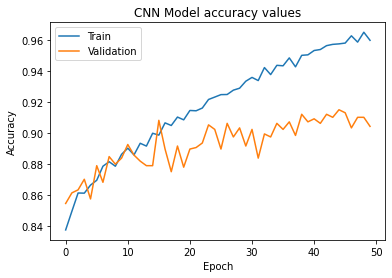

In [ ]:
_# Plot training & validation loss values
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()